# Predict response to stimuli: lstm for time series

In a *lstm timeseries* problem, we aim to predict the response of a stimuli, as a time series data. The input is a stimuli vs time and the output is response vs time curve. Depending on how we train the network the response curve could represent average response to the stimuli from different spatial locations or could represet response form a single spatial location. 

This notebook builds an LSTM based model to predict the response to external stimuli. To do this, we'll provide the model with timeseries of stimuli and use the return sequences to return an output vector that has the same shape as that of the input time series, the output represents response to the stimuli.

In [1]:
import keras, tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The input csv file contains N columns of response as tabular data, we load the data from disk and read it to a numpy array

In [43]:
stimuli_data = pd.read_csv("../stimuli_response_data/stimuli.csv")
stimuli_data_tuple = stimuli_data.to_numpy()
stimuli_data_array = np.asarray(stimuli_data_tuple)
type(stimuli_data_array)

stimuli_data_array = np.reshape(stimuli_data_array, (stimuli_data_array.shape[1], stimuli_data_array.shape[0], 1))

print("input data shape",stimuli_data_array.shape)
input_shape = (stimuli_data_array.shape[1],stimuli_data_array.shape[2])
lstm_units = 128

input data shape (4, 999, 1)


The dataset contains 4 colums of the stimuli and the first number represents the number of timepoints present in the data

In [44]:
from keras import layers, models
from keras.layers import LSTM, Conv1D, Dense
img_input = layers.Input(shape = input_shape)
x = (LSTM(lstm_units, return_sequences=True))(img_input)
x = (LSTM(lstm_units//2, return_sequences=True))(x)
x = (LSTM(lstm_units//4, return_sequences=True))(x)
x = (LSTM(1, return_sequences=True))(x)
outputs = x
model = models.Model(img_input, outputs)
opt = keras.optimizers.Adam(lr=0.001)

model.compile(loss='mse',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 999, 1)]          0         
                                                                 
 lstm_8 (LSTM)               (None, 999, 128)          66560     
                                                                 
 lstm_9 (LSTM)               (None, 999, 64)           49408     
                                                                 
 lstm_10 (LSTM)              (None, 999, 32)           12416     
                                                                 
 lstm_11 (LSTM)              (None, 999, 1)            136       
                                                                 
Total params: 128,520
Trainable params: 128,520
Non-trainable params: 0
_________________________________________________________________


c:\Users\rando\anaconda3\envs\naparienv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Now let us plot the network graph using keras plot_model

<IPython.core.display.Image object>


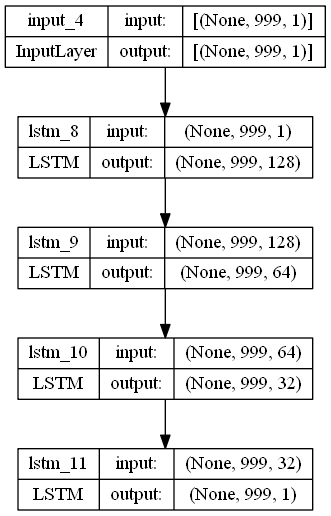

In [45]:
from keras.utils import plot_model

model_inline = plot_model(model, to_file = './model_time_series.png', 
show_shapes = True, show_layer_names=True)

print(model_inline)
model_inline